In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm, metrics
from sklearn.decomposition import PCA
import time
import plotly.graph_objects as go

In [23]:
# --- Load the dataset ---
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = [
    'Class label', 'Alcohol', 'Malic acid', 'Ash',
    'Alcalinity of ash', 'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines', 'Proline'
]

In [27]:
# Display the first 5 rows
print(df_wine.head())

   Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0            1    14.23        1.71  2.43               15.6        127   
1            1    13.20        1.78  2.14               11.2        100   
2            1    13.16        2.36  2.67               18.6        101   
3            1    14.37        1.95  2.50               16.8        113   
4            1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             5.64  1.04                          3.92  

In [29]:
# --- Split into train/test ---
x = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=48)
print(f"Training set size: {len(x_train)} samples")
print(f"Test set size: {len(x_test)} samples")

Training set size: 124 samples
Test set size: 54 samples


In [31]:
# --- Standardize ---
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

In [33]:
# --- Covariance matrix ---
cov_mat = np.cov(x_train_std.T)
print(f"Covariance matrix shape: {cov_mat.shape}")

Covariance matrix shape: (13, 13)


In [35]:
# --- Eigenvalues and Eigenvectors ---
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.79238486 2.62792025 1.39308561 0.98592278 0.87537781 0.6705819
 0.48279911 0.09713136 0.31751144 0.29032342 0.23963852 0.15560255
 0.17741144]


In [37]:
# --- Explained variance ---
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

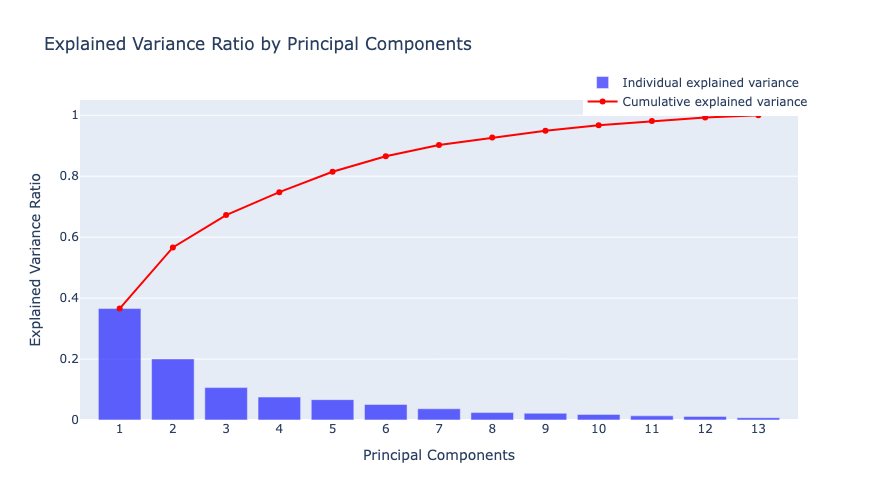

In [39]:
# --- Plot explained variance with Plotly ---
fig_var = go.Figure()

fig_var.add_trace(go.Bar(
    x=list(range(1, 14)),
    y=var_exp,
    name='Individual explained variance',
    marker_color='blue',
    opacity=0.6
))
fig_var.add_trace(go.Scatter(
    x=list(range(1, 14)),
    y=cum_var_exp,
    mode='lines+markers',
    name='Cumulative explained variance',
    marker=dict(color='red')
))

fig_var.update_layout(
    title='Explained Variance Ratio by Principal Components',
    xaxis_title='Principal Components',
    yaxis_title='Explained Variance Ratio',
    xaxis=dict(tickmode='linear'),
    yaxis=dict(range=[0, 1.05]),
    legend=dict(x=0.7, y=1.1),
    width=800,
    height=500
)

fig_var.show()

In [41]:
# --- Eigen pairs ---
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
print("\nEigen pairs sorted by eigenvalue (descending):")
for val, vec in eigen_pairs:
    print(f"Eigenvalue: {val}")


Eigen pairs sorted by eigenvalue (descending):
Eigenvalue: 4.792384857696385
Eigenvalue: 2.6279202468888885
Eigenvalue: 1.393085613820876
Eigenvalue: 0.9859227826250792
Eigenvalue: 0.8753778109909693
Eigenvalue: 0.6705818994127292
Eigenvalue: 0.48279910910777957
Eigenvalue: 0.31751144310077384
Eigenvalue: 0.2903234222906942
Eigenvalue: 0.2396385171801441
Eigenvalue: 0.17741144274578693
Eigenvalue: 0.1556025523055307
Eigenvalue: 0.0971313587449329


In [43]:
# --- Construct projection matrix W ---
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 1.56650889e-01  4.85795595e-01]
 [-2.57516773e-01  2.31195791e-01]
 [ 5.24936728e-03  3.91112205e-01]
 [-2.48043233e-01  7.45554344e-02]
 [ 1.52724776e-01  2.35643992e-01]
 [ 3.80291249e-01  6.98178486e-02]
 [ 4.20585828e-01 -2.67703410e-04]
 [-3.21608484e-01  8.73711553e-02]
 [ 2.95546162e-01  5.01268570e-02]
 [-5.91277839e-02  5.04024398e-01]
 [ 2.86828914e-01 -2.79409319e-01]
 [ 3.73070237e-01 -1.26204380e-01]
 [ 2.95001704e-01  3.65290369e-01]]


In [45]:
# --- Project training data ---
x_train_pca = x_train_std.dot(w)
x_test_pca = x_test_std.dot(w)
print(f"x_train_pca shape: {x_train_pca.shape}")

x_train_pca shape: (124, 2)


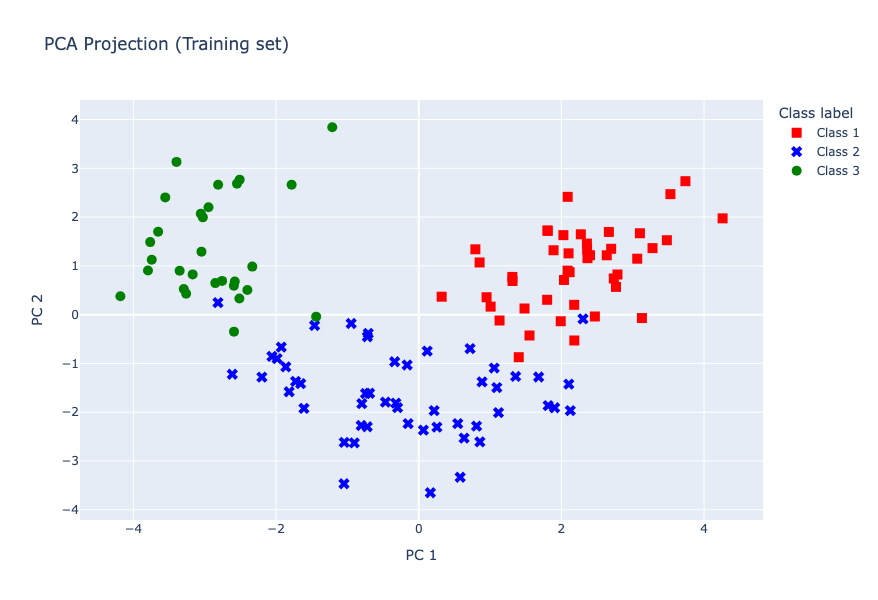

In [51]:
# --- Plot PCA scatter plot with Plotly ---
colors = ['red', 'blue', 'green']
markers = ['square', 'x', 'circle']
unique_labels = np.unique(y_train)

fig_pca = go.Figure()

for l, c, m in zip(unique_labels, colors, markers):
    indices = np.where(y_train == l)
    fig_pca.add_trace(go.Scatter(
        x=x_train_pca[indices, 0][0],
        y=x_train_pca[indices, 1][0],
        mode='markers',
        name=f'Class {int(l)}',
        marker_symbol=m,
        marker=dict(color=c, size=10)
    ))

fig_pca.update_layout(
    title='PCA Projection (Training set)',
    xaxis_title='PC 1',
    yaxis_title='PC 2',
    legend_title='Class label',
    width=800,
    height=600
)

fig_pca.show()

In [53]:
# --- SVM without PCA ---
start_time = time.time()
svm_no_pca = svm.SVC(kernel='linear')
svm_no_pca.fit(x_train, y_train)
y_pred_no_pca = svm_no_pca.predict(x_test)
no_pca_time = time.time() - start_time
print("Without PCA - Accuracy:")
print(metrics.accuracy_score(y_test, y_pred_no_pca))

Without PCA - Accuracy:
0.9444444444444444


In [55]:
# --- SVM with manual PCA ---
start_time = time.time()
svm_pca = svm.SVC(kernel='linear')
svm_pca.fit(x_train_pca, y_train)
y_pred_pca = svm_pca.predict(x_test_pca)
pca_time = time.time() - start_time
print("\nWith PCA - Accuracy:")
print(metrics.accuracy_score(y_test, y_pred_pca))
print("\nTime Comparison:")
print(f"No PCA: {no_pca_time} seconds, PCA: {pca_time} seconds")


With PCA - Accuracy:
0.9444444444444444

Time Comparison:
No PCA: 0.16791391372680664 seconds, PCA: 0.002908945083618164 seconds


In [57]:
# --- SVM with sklearn PCA ---
pca = PCA(n_components=2)
x_train_pca2 = pca.fit_transform(x_train_std)
x_test_pca2 = pca.transform(x_test_std)

clf = svm.SVC(kernel='linear', C=1, random_state=42)
clf.fit(x_train_pca2, y_train)
y_pred = clf.predict(x_test_pca2)
print("\nWith sklearn PCA - Accuracy:")
print(metrics.accuracy_score(y_test, y_pred))


With sklearn PCA - Accuracy:
0.9444444444444444


In [59]:
# --- Explained variance with sklearn PCA ---
pca_full = PCA(n_components=13)
x_pca_full = pca_full.fit_transform(x_train_std)
explained_variance = pca_full.explained_variance_ratio_

print("\nExplained Variance by Principal Components:")
for i, var in enumerate(explained_variance, start=1):
    print(f"PC {i}: {var*100:.2f}%")


Explained Variance by Principal Components:
PC 1: 36.57%
PC 2: 20.05%
PC 3: 10.63%
PC 4: 7.52%
PC 5: 6.68%
PC 6: 5.12%
PC 7: 3.68%
PC 8: 2.42%
PC 9: 2.22%
PC 10: 1.83%
PC 11: 1.35%
PC 12: 1.19%
PC 13: 0.74%


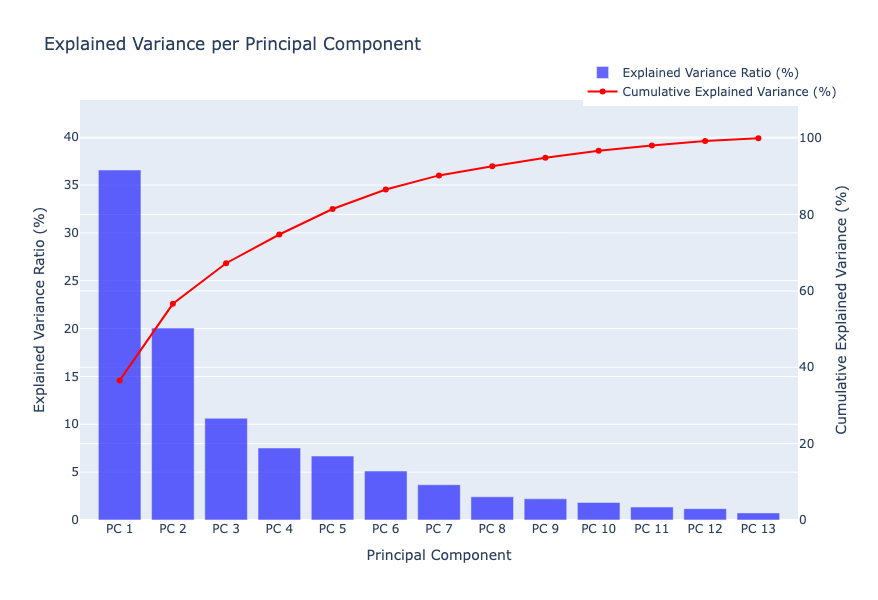

In [61]:
# --- Plot explained variance & cumulative with Plotly ---
cumulative_explained_variance = np.cumsum(explained_variance)

fig_full_var = go.Figure()

fig_full_var.add_trace(go.Bar(
    x=[f'PC {i}' for i in range(1, len(explained_variance) + 1)],
    y=explained_variance * 100,
    name='Explained Variance Ratio (%)',
    marker_color='blue',
    opacity=0.6
))
fig_full_var.add_trace(go.Scatter(
    x=[f'PC {i}' for i in range(1, len(cumulative_explained_variance) + 1)],
    y=cumulative_explained_variance * 100,
    mode='lines+markers',
    name='Cumulative Explained Variance (%)',
    marker=dict(color='red'),
    yaxis='y2'
))

fig_full_var.update_layout(
    title='Explained Variance per Principal Component',
    xaxis_title='Principal Component',
    yaxis=dict(title='Explained Variance Ratio (%)', range=[0, max(explained_variance * 100) * 1.2]),
    yaxis2=dict(title='Cumulative Explained Variance (%)', overlaying='y', side='right', range=[0, 110]),
    legend=dict(x=0.7, y=1.1),
    width=900,
    height=600
)

fig_full_var.show()
